In [2]:
import numpy as np
import scipy as sp
from more_itertools import pairwise
import pandas as pd
import scipy.special
import climpy.utils.wrf_chem_utils as wrf_chem
import matplotlib.pyplot as plt
from climpy.utils.wrf_chem_mosaic_utils import get_mosaic_bins

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

## Diagnostics to debug WRF-Chem mapping between MADE mods to discrete bins (module_optical_averaging.F):

The example was designed for the MADE/SORGAM implementation in WRF-Chem (chem_opt=100), which uses 3 log normal modes, to describe aerosols.
See for details https://patarnott.com/pdf/SizeDistributions.pdf, equations 24-27

You can plugin your numbers to check how the mapping looks like

In [3]:
# Parameters of the distribution for 3 modes


# CASE 1: set unit mass to debug sect02 routine in WRF
masses = np.array([1, 1, 1])  # ug m^-3
dgs = np.array([1.32e-8, 8.678e-8, 10.8e-6])  # m

# CASE 2: heavy dust (c mode), little anthropogenic (j mode) aerosols, ignore i mode
masses = np.array([1, 10, 2500])  # ug m^-3
dgs = np.array([1.32e-8, 8.678e-8, 10.8e-6])  # m

# CASE 3: like case 2 but with realistic dgs
masses = np.array([1, 50, 1500])  # ug m^-3
dgs = np.array([2e-8, 9e-8, 4.8e-7])  # m


sgs = np.array([1.7, 2.0, 2.5])
# derive V and N and then m0 and m3
density = 1800  # kg*m^-3
volumes = masses / density * 1.0e-9  # m^3 / m^3
#
m3s = volumes / (np.pi/6)
# V_0 = N_0  * pi/6 * dg^3 * exp(9/2 ln(sg)^2)
# dvm = dgs * np.exp(3 * np.log(sgs)**2)  # volume median diameter
dstar = dgs * np.exp(3/2 * np.log(sgs)**2)  # volume median diameter
# M3 = M0  * dg^3 * exp(9/2 ln(sg)^2)
m0s = m3s / (dgs**3 * np.exp(9/2 * np.log(sgs)**2))

In [4]:
print('Setup the parameters of the three log normal modes')
data = np.array([sgs, dgs, m0s, m3s, masses, volumes, dstar]).transpose()
pd.DataFrame(data, columns=["sg", "dg (m)", 'M0 (# m^-3 )', 'M3', 'Masses (ug m^-3)', 'Volumes (m^3 m^-3)', 'dstar, (m)'])


Setup the parameters of the three log normal modes


,sg,dg (m),M0 (# m^-3 ),M3,Masses (ug m^-3),Volumes (m^3 m^-3),"dstar, (m)"
0,1.7,2.000000e-08,3.735654e+10,1.061033e-12,1.0,5.555556e-13,3.051083e-08
1,2.0,9.000000e-08,8.375484e+09,5.305165e-11,50.0,2.777778e-11,1.850247e-07
2,2.5,4.800000e-07,3.290539e+08,1.591549e-09,1500.0,8.333333e-10,1.691159e-06


In [5]:
# generate MOSAIC 8 bins
dlo_um = 0.039063e-6  # m
dhi_um = 10e-6  # m
d_stag = np.logspace(np.log(dlo_um), np.log(dhi_um), 9, base=np.e)
d_stag = get_mosaic_bins()
print(d_stag*1.0e6)

[ 0.039063    0.07812587  0.1562515   0.3125025   0.625004    1.250006
  2.500008    5.000008   10.        ]


Sample the distributions and visualize weights

In [6]:
diams = np.logspace(-9, -4, 100)
diams = np.logspace(-9, -3, 200)
radii = diams / 2

# sample the distributions
dNdlogps = wrf_chem.sample_WRF_MADE_size_distributions(diams, sgs, dgs, m3s, m0s)

# compute 3rd moment/volume
dVdlogps = []
# and cross section, since it is involved in the optical depth calculation
dAdlogps = []
for dNdlogp in dNdlogps:
     dVdlogp = dNdlogp * 4 / 3 * np.pi * (radii*10**-6) ** 3
     dVdlogps.append(dVdlogp)
     dAdlogp = dNdlogp * np.pi * (radii*10**-6) ** 2
     dAdlogps.append(dAdlogp)

In [7]:
mode_labels = ["i", "j", 'c']


def plot_size_distribution_mapping_from_modes_to_bins(diams, dVdlogps, m3_factors_by_bin, d_stag):
    fig = plt.figure(constrained_layout=True)#, figsize=(get_full_screen_page_width_inches()/2, 9.85416667), dpi=MY_DPI)
    #plt.grid(axis='y')

    # plot the boundaries of the bins
    for d in d_stag:
        plt.axvline(d*1.0e6, color='r', lw=0.5)

    #for [d_min, d_max], V_factors in zip(pairwise(d_stag), m3_factors_by_bin):  # m
    #    ind = np.logical_and(diams >= d_min, diams <= d_max)
        #for dVdlogp, V_factor in zip(dVdlogps, V_factors):
            #plt.fill_between(radii[ind]*10**6, dVdlogp[ind], alpha=0.3, label='{:.3f}'.format(V_factor))#, color='orange')
        #plt.plot(diams*10**6, dVdlogp, '-', markersize=1)#, color='orange')

    for dVdlogp, V_factor, label in zip(dVdlogps, V_factors, mode_labels):
        plt.plot(diams*10**6, dVdlogp, '-', markersize=1, label=label)#, color='orange')

    plt.legend()
    plt.title('MADE modes mapped to 8 MOSAIC bins')

    plt.xscale('log')
    #plt.yscale('log')
    # plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
    plt.xlabel('Diameter, ($\mu $m)')
    plt.ylabel('dV/dlogr, ($\mu m^3/cm^3$)')


In [20]:
# Loop through the bins and compute factors for m0 and m3 (and also wet radius for debugging WRF)

m0_factors_by_bin = []
m3_factors_by_bin = []
r_wet_by_bin = []
for d_min, d_max in pairwise(d_stag):  # m
    #d_min = 10**-20  # m
    #d_max = 10 * 10 ** -6  # m
    N_factors, V_factors = wrf_chem.compute_MADE_bounded_distribution_factors(d_min, d_max, sgs, dgs, m3s, m0s)
    m0_factors_by_bin+=(N_factors, )
    m3_factors_by_bin+=(V_factors, )

    d_wet = (6/np.pi * np.sum(volumes * V_factors) / np.sum(m0s*N_factors)) ** (1/3) #  m
    r_wet_by_bin += (d_wet/2,)

# dims are: d, mode
#m0_factors_by_bin = np.array(m0_factors_by_bin)
#m3_factors_by_bin = np.array(m3_factors_by_bin)

# Debug wet radius too. Loop through the bins and compute r_wet


Text(0, 0.5, 'dV/dlogr, ($\\mu m^3/cm^3$)')

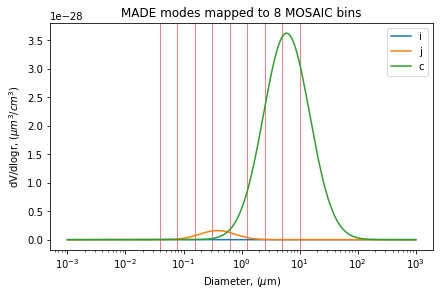

In [9]:
# Visualize dV
plot_size_distribution_mapping_from_modes_to_bins(diams, dVdlogps, m3_factors_by_bin, d_stag)
plt.ylabel('dV/dlogr, ($\mu m^3/cm^3$)')

In [29]:
print('factors for m3 mapping (volume or mass)')
df = pd.DataFrame(m3_factors_by_bin, columns=mode_labels)
display(df)
# The sum across bins is:
display(df.sum())

factors for m3 mapping (volume or mass)


,i,j,c
0,4.648719e-01,0.010686,0.000001
1,1.532969e-01,0.088448,0.000034
2,1.107051e-02,0.288723,0.000612
3,1.657749e-04,0.374766,0.006285
4,4.917126e-07,0.193822,0.037229
5,2.803411e-10,0.039743,0.127443
6,3.014256e-14,0.003199,0.252511
7,0.000000e+00,0.000100,0.289879


i    0.629406
j    0.999486
c    0.713994
dtype: float64

In [28]:
print('factors for m0 mapping (number)')
df = pd.DataFrame(m0_factors_by_bin, columns=mode_labels)
display(df)
# The sum across bins is:
display(df.sum())

factors for m0 mapping (number)


,i,j,c
0,9.842926e-02,3.048569e-01,0.020685
1,5.062648e-03,3.678190e-01,0.086538
2,5.338757e-05,1.767954e-01,0.209440
3,1.106462e-07,3.366951e-02,0.293604
4,4.386541e-11,2.514458e-03,0.238526
5,3.275158e-15,7.275454e-05,0.112265
6,0.000000e+00,8.064776e-07,0.030578
7,0.000000e+00,3.393182e-09,0.004812


i    0.103545
j    0.885729
c    0.996447
dtype: float64

In [26]:
print('r wet derived from volume and number concentrations')
df = pd.DataFrame(r_wet_by_bin, columns=('r wet',))
df = pd.DataFrame({'d_left':d_stag[:-1], 'd_right':d_stag[1:],'r wet':r_wet_by_bin})
display(df)

r wet derived from volume and number concentrations


,d_left,d_right,r wet
0,3.906300e-08,7.812587e-08,5.542441e-08
1,7.812587e-08,1.562515e-07,1.141783e-07
2,1.562515e-07,3.125025e-07,2.190216e-07
3,3.125025e-07,6.250040e-07,4.289588e-07
4,6.250040e-07,1.250006e-06,8.872732e-07
5,1.250006e-06,2.500008e-06,1.760639e-06
6,2.500008e-06,5.000008e-06,3.418002e-06
7,5.000008e-06,1.000000e-05,6.629708e-06


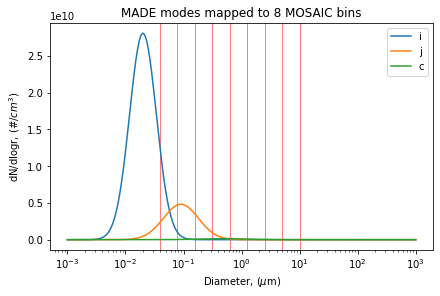

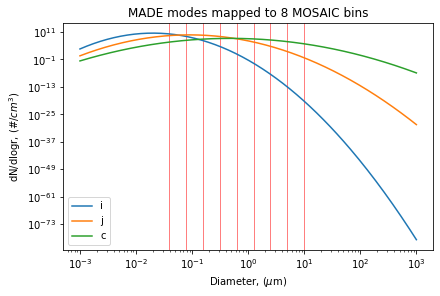

In [11]:
# Visualize dN
plot_size_distribution_mapping_from_modes_to_bins(diams, dNdlogps, m0_factors_by_bin, d_stag)
plt.ylabel('dN/dlogr, (#$/cm^3$)')

# The same plot, but log scale
plot_size_distribution_mapping_from_modes_to_bins(diams, dNdlogps, m0_factors_by_bin, d_stag)
plt.ylabel('dN/dlogr, (#$/cm^3$)')
# Have to turn on log scale, due to spread of the magnitudes
plt.yscale('log')

In [12]:
print('factors for m0 mapping (number of particles). Do not confuse with N in the bin, which is = N0 * factor')
df = pd.DataFrame(m0_factors_by_bin, columns=mode_labels)
display(df)
# The sum across bins is:
display(df.sum())

factors for m0 mapping (number of particles). Do not confuse with N in the bin, which is = N0 * factor


,i,j,c
0,9.842926e-02,3.048569e-01,0.020685
1,5.062648e-03,3.678190e-01,0.086538
2,5.338757e-05,1.767954e-01,0.209440
3,1.106462e-07,3.366951e-02,0.293604
4,4.386541e-11,2.514458e-03,0.238526
5,3.275158e-15,7.275454e-05,0.112265
6,0.000000e+00,8.064776e-07,0.030578
7,0.000000e+00,3.393182e-09,0.004812


i    0.103545
j    0.885729
c    0.996447
dtype: float64

Text(0.5, 1.0, 'i-mode /= 10, c-mode *= 100')

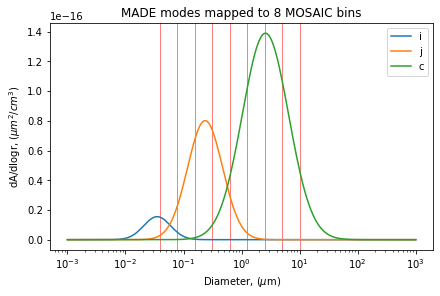

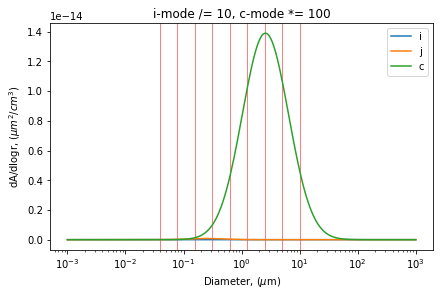

In [13]:
# Visualize dA
# TODO: compute properly m2 factors later
m2_factors_by_bin = None
plot_size_distribution_mapping_from_modes_to_bins(diams, dAdlogps, m2_factors_by_bin, d_stag)
plt.ylabel('dA/dlogr, ($\mu m^2/cm^3$)')

# and one more case: aitken mode reduced by 10 and coarse mode boosted by 100
dAdlogps_without_i = [dA.copy() for dA in dAdlogps]
dAdlogps_without_i[0][:] /= 10
dAdlogps_without_i[2][:] *= 100
plot_size_distribution_mapping_from_modes_to_bins(diams, dAdlogps_without_i, m2_factors_by_bin, d_stag)
plt.ylabel('dA/dlogr, ($\mu m^2/cm^3$)')
plt.title('i-mode /= 10, c-mode *= 100')


